In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from urllib.request import urlopen
from zipfile import ZipFile
from tqdm import trange, tqdm

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from scipy import stats

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset, Sampler
from torch.utils.data.sampler import RandomSampler
from sklearn.metrics import r2_score


In [3]:
path = "/content/drive/MyDrive/Colab_Notebooks/ADS_505/Module_3/LD2011_2014.csv"
data = pd.read_csv(path)

<ipython-input-3-b7512bbfdc46>:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


In [4]:
# rename the first column for clarity
data.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace= True)

# Convert the timestamp column to a datetime object for easier analysis
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Identifying non-numeric columns
non_numeric_columns = data.select_dtypes(include=["object"]).columns
non_numeric_columns

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_360', 'MT_361', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=369)

In [5]:
# Convert string values with commas as decimal separators to floats
for col in non_numeric_columns:
    data[col] = data[col].str.replace(',', '.').astype(float)

# Now, convert kW to kWh by dividing all values by 4
data.iloc[:, 1:] = data.iloc[:, 1:] / 4

data.dtypes

Timestamp    datetime64[ns]
MT_001              float64
MT_002              float64
MT_003              float64
MT_004              float64
                  ...      
MT_366              float64
MT_367              float64
MT_368              float64
MT_369              float64
MT_370              float64
Length: 371, dtype: object

<ipython-input-7-1214a23f4e15>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Mean Consumption'] = data.iloc[:, 1:371].mean(axis=1)
<ipython-input-7-1214a23f4e15>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Median Consumption'] = data.iloc[:, 1:371].median(axis=1)


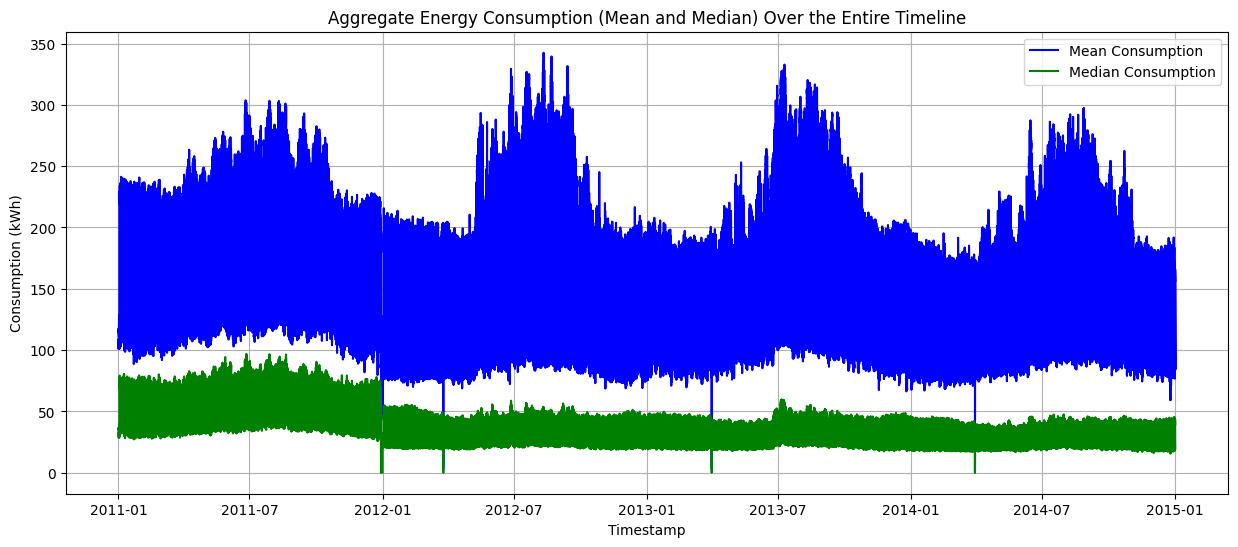

In [7]:
# Calculate the mean and median consumption across all clients
data['Mean Consumption'] = data.iloc[:, 1:371].mean(axis=1)
data['Median Consumption'] = data.iloc[:, 1:371].median(axis=1)

# Plotting the aggregate data
plt.figure(figsize=(15, 6))
plt.plot(data['Timestamp'], data['Mean Consumption'], label='Mean Consumption', color='blue')
plt.plot(data['Timestamp'], data['Median Consumption'], label='Median Consumption', color='green')

plt.title('Aggregate Energy Consumption (Mean and Median) Over the Entire Timeline')
plt.xlabel('Timestamp')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-8-1de2c1e6a06d>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_avg = hourly_data.groupby('Hour').mean()


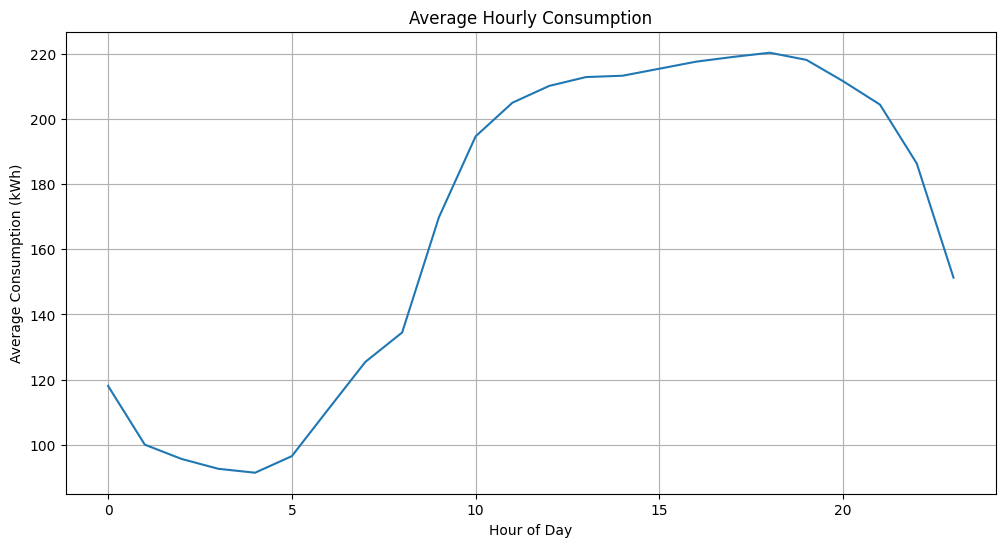

In [ ]:
# Grouping data by hour and calculating the mean
hourly_data = data.copy()
hourly_data['Hour'] = hourly_data['Timestamp'].dt.hour
hourly_avg = hourly_data.groupby('Hour').mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg['Mean Consumption'])
plt.title('Average Hourly Consumption')
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption (kWh)')
plt.grid(True)
plt.show()

It is seen that at 5.00am there is a dip in consumption. The consumption is minimal in that time. Mainly people sleep in that time. The consumption increase when it is morning and the working hour begins form 9.00am. The consumption remains relatively high and stable from mid-morning to late evening, indicating consistent energy use throughout the day. Starting around 8 PM, there's a noticeable decline in consumption, which continues into the night, reflecting reduced activity as people likely head to bed

<ipython-input-9-4b6d8b0807ba>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_avg = daily_data.groupby('DayOfWeek').mean()


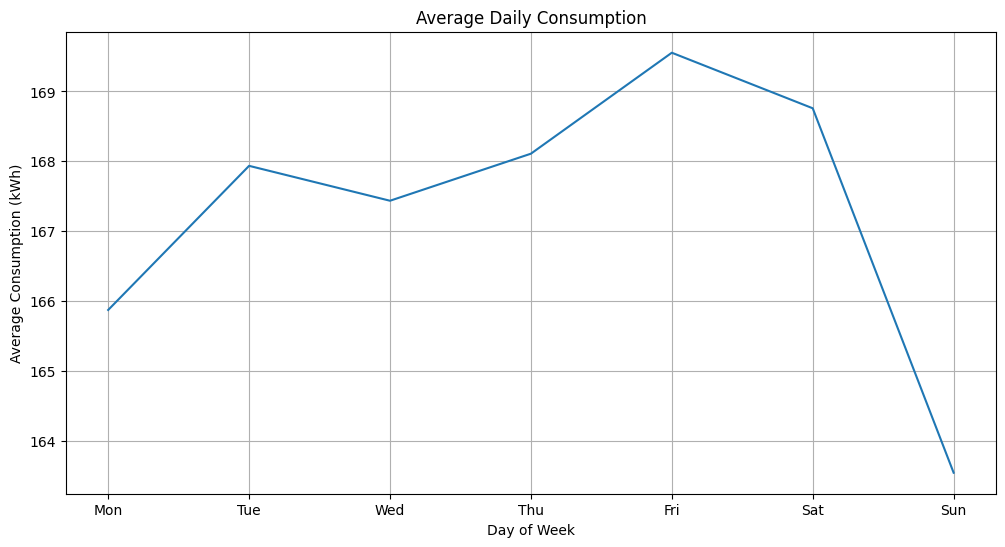

In [ ]:
# Grouping data by day of the week and calculating the mean
daily_data = data.copy()
daily_data['DayOfWeek'] = daily_data['Timestamp'].dt.dayofweek
daily_avg = daily_data.groupby('DayOfWeek').mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(daily_avg.index, daily_avg['Mean Consumption'])
plt.title('Average Daily Consumption')
plt.xlabel('Day of Week')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()

The consumption starts at a lower point on Monday and slightly fluctuates but generally increases as the week progresses.The peak consumption occurs on Friday, suggesting that this day might have the highest activity level during the week, which could be attributed to commercial activity or end-of-week routines in residential areas.There is a significant drop in consumption on Sunday, which is the lowest among all days. This drop might indicate reduced commercial activity and a more relaxed pace in residential usage, as it is traditionally a rest day or a non-working day for many sectors.Saturday shows a relatively high consumption, though not as high as Friday, possibly reflecting a mix of relaxed residential activity and ongoing commercial operations, particularly in services that operate on weekends.

<ipython-input-8-d631d4ae3661>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_avg = weekly_data.groupby('WeekOfYear').mean()


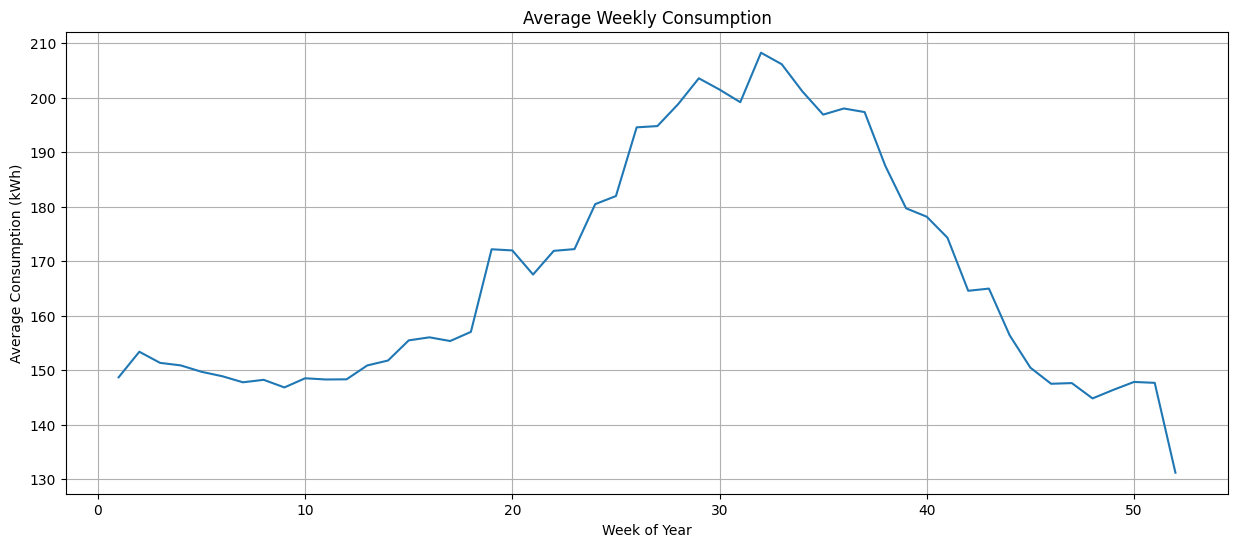

In [8]:
# Grouping data by week of the year and calculating the mean
weekly_data = data.copy()
weekly_data['WeekOfYear'] = weekly_data['Timestamp'].dt.isocalendar().week
weekly_avg = weekly_data.groupby('WeekOfYear').mean()

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(weekly_avg.index, weekly_avg['Mean Consumption'])
plt.title('Average Weekly Consumption')
plt.xlabel('Week of Year')
plt.ylabel('Average Consumption (kWh)')
plt.grid(True)
plt.show()


### Probabilistic Forecasting with Autoregressive Recurrent Networks


In [3]:
def prep_data(data, covariates, data_start, train = True):
  # data: time series data in inserted
  # convariates: additional variable that might effect the time series.
  # ei data time series ektar shathe ekta related kore rakhe.

    time_len = data.shape[0]
    input_size = window_size-stride_size
    windows_per_series = np.full((num_series), (time_len-input_size) // stride_size)
    if train: windows_per_series -= (data_start+stride_size-1) // stride_size
    total_windows = np.sum(windows_per_series)
    x_input = np.zeros((total_windows, window_size, 1 + num_covariates + 1), dtype='float32')
    label = np.zeros((total_windows, window_size), dtype='float32')
    v_input = np.zeros((total_windows, 2), dtype='float32')
    count = 0
    if not train:
        covariates = covariates[-time_len:]
    for series in trange(num_series):
        cov_age = stats.zscore(np.arange(total_time-data_start[series]))
        if train:
            covariates[data_start[series]:time_len, 0] = cov_age[:time_len-data_start[series]]
        else:
            covariates[:, 0] = cov_age[-time_len:]
        for i in range(windows_per_series[series]):
            if train:
                window_start = stride_size*i+data_start[series]
            else:
                window_start = stride_size*i
            window_end = window_start+window_size
            x_input[count, 1:, 0] = data[window_start:window_end-1, series]
            x_input[count, :, 1:1+num_covariates] = covariates[window_start:window_end, :]
            x_input[count, :, -1] = series
            label[count, :] = data[window_start:window_end, series]
            nonzero_sum = (x_input[count, 1:input_size, 0]!=0).sum()
            if nonzero_sum == 0:
                v_input[count, 0] = 0
            else:
                v_input[count, 0] = np.true_divide(x_input[count, 1:input_size, 0].sum(),nonzero_sum)+1
                x_input[count, :, 0] = x_input[count, :, 0]/v_input[count, 0]
                if train:
                    label[count, :] = label[count, :]/v_input[count, 0]
            count += 1
    return x_input, v_input, label

def gen_covariates(times, num_covariates):
    covariates = np.zeros((times.shape[0], num_covariates))
    for i, input_time in enumerate(times):
        covariates[i, 1] = input_time.weekday()
        covariates[i, 2] = input_time.hour
        covariates[i, 3] = input_time.month
    for i in range(1,num_covariates):
        covariates[:,i] = stats.zscore(covariates[:,i])
    return covariates[:, :num_covariates]



In [4]:
name = 'LD2011_2014.txt'
save_name = 'elect'
window_size = 192
stride_size = 24
num_covariates = 4
train_start = '2011-01-01 00:00:00'
train_end = '2014-08-31 23:00:00'
test_start = '2014-08-25 00:00:00' #need additional 7 days as given info
test_end = '2014-09-07 23:00:00'

save_path = os.path.join('data', save_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)
csv_path = os.path.join(save_path, name)
if not os.path.exists(csv_path):
    zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(save_path)

data_frame = pd.read_csv(csv_path, sep=";", index_col=0, parse_dates=True, decimal=',')
data_frame = data_frame.resample('1H',label = 'left',closed = 'right').sum()[train_start:test_end]
data_frame.fillna(0, inplace=True)
covariates = gen_covariates(data_frame[train_start:test_end].index, num_covariates)
train_data = data_frame[train_start:train_end].values
test_data = data_frame[test_start:test_end].values
data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series
total_time = data_frame.shape[0] #32304
num_series = data_frame.shape[1] #370
X_train, v_train, y_train = prep_data(train_data, covariates, data_start)
X_test, v_test, y_test = prep_data(test_data, covariates, data_start, train=False)


100%|██████████| 370/370 [00:00<00:00, 1808.31it/s]


In [5]:
class DeepAR(nn.Module):
    def __init__(self,
                num_class=num_series,
                embedding_dim=20,
                cov_dim=num_covariates,
                lstm_hidden_dim=40,
                lstm_layers=3,
                lstm_dropout=0.1,
                sample_times=200,
                predict_start=window_size-stride_size,
                predict_steps=stride_size,
                device=torch.device('cuda')):
        super(DeepAR, self).__init__()
        self.lstm_layers = lstm_layers
        self.lstm_hidden_dim = lstm_hidden_dim
        self.device = device
        self.sample_times = sample_times
        self.predict_steps = predict_steps
        self.predict_start = predict_start
        self.embedding = nn.Embedding(num_class, embedding_dim)

        self.lstm = nn.LSTM(input_size=1+cov_dim+embedding_dim,
                            hidden_size=lstm_hidden_dim,
                            num_layers=lstm_layers,
                            bias=True,
                            batch_first=False,
                            dropout=lstm_dropout)

        self.relu = nn.ReLU()
        self.distribution_mu = nn.Linear(lstm_hidden_dim * lstm_layers, 1)
        self.distribution_presigma = nn.Linear(lstm_hidden_dim * lstm_layers, 1)
        self.distribution_sigma = nn.Softplus()

    def forward(self, x, idx, hidden, cell):
        onehot_embed = self.embedding(idx) # use an embedding corresponding to time series idx
        lstm_input = torch.cat((x, onehot_embed), dim=2) # concat embedding with the training data
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell)) # process through LSTM, batch_first is False by default

        # use h from all three layers to calculate mu and sigma
        hidden_permute = hidden.permute(1, 2, 0).contiguous().view(hidden.shape[1], -1)

        mu = self.distribution_mu(hidden_permute)
        pre_sigma = self.distribution_presigma(hidden_permute)
        sigma = self.distribution_sigma(pre_sigma)  # softplus to make sure standard deviation is positive
        return torch.squeeze(mu), torch.squeeze(sigma), hidden, cell

    def init_hidden(self, input_size):
        return torch.zeros(self.lstm_layers, input_size, self.lstm_hidden_dim, device=self.device)

    def init_cell(self, input_size):
        return torch.zeros(self.lstm_layers, input_size, self.lstm_hidden_dim, device=self.device)

    def test(self, x, v_batch, id_batch, hidden, cell):
        batch_size = x.shape[1]
        samples = torch.zeros(self.sample_times, batch_size, self.predict_steps,
                                   device=self.device)
        for j in range(self.sample_times):
            decoder_hidden = hidden
            decoder_cell = cell
            for t in range(self.predict_steps):
                mu_de, sigma_de, decoder_hidden, decoder_cell = self(x[self.predict_start + t].unsqueeze(0),
                                                                     id_batch, decoder_hidden, decoder_cell)
                gaussian = torch.distributions.normal.Normal(mu_de, sigma_de)
                pred = gaussian.sample()  # not scaled
                samples[j, :, t] = pred * v_batch[:, 0] + v_batch[:, 1]
                if t < (self.predict_steps - 1):
                    x[self.predict_start + t + 1, :, 0] = pred

        sample_mu = torch.median(samples, dim=0)[0]
        sample_sigma = samples.std(dim=0)
        return samples, sample_mu, sample_sigma

def loss_fn(mu: Variable, sigma: Variable, labels: Variable):
    zero_index = (labels != 0)
    distribution = torch.distributions.normal.Normal(mu[zero_index], sigma[zero_index])
    likelihood = distribution.log_prob(labels[zero_index])
    return -torch.mean(likelihood)




In [6]:
class TrainDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.train_len = self.data.shape[0]

    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]), self.label[index])



In [7]:
class TestDataset(Dataset):
    def __init__(self, data, v, label):
        self.data = data
        self.v = v
        self.label = label
        self.test_len = self.data.shape[0]

    def __len__(self):
        return self.test_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]),self.v[index],self.label[index])

In [8]:
class WeightedSampler(Sampler):
    def __init__(self, v, replacement=True):
        self.weights = torch.as_tensor(np.abs(v[:,0])/np.sum(np.abs(v[:,0])), dtype=torch.double)
        self.num_samples = self.weights.shape[0]
        self.replacement = replacement

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, self.replacement).tolist())

    def __len__(self):
        return self.num_samples


In [9]:
train_set = TrainDataset(data=X_train, label=y_train)
test_set = TestDataset(data=X_test, v=v_test, label=y_test)
sampler = WeightedSampler(v=v_train) # Use weighted sampler instead of random sampler
train_loader = DataLoader(train_set, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_set, batch_size=256, sampler=RandomSampler(test_set))

In [10]:

def accuracy_RMSE(mu: torch.Tensor, labels: torch.Tensor, relative = False):
    zero_index = (labels != 0)
    diff = torch.sum(torch.mul((mu[zero_index] - labels[zero_index]), (mu[zero_index] - labels[zero_index]))).item()
    if relative is False:
        return [diff, torch.sum(zero_index).item(), torch.sum(zero_index).item()]
    else:
        summation = torch.sum(torch.abs(labels[zero_index])).item()
        if summation == 0:
            logger.error('summation denominator error! ')
        return [diff, summation, torch.sum(zero_index).item()]


def update_metrics(raw_metrics, input_mu, input_sigma, sample_mu, labels, predict_start, samples=None, relative=False):
    # TODO: use samples to calcualte rou50, rou90 metrics
    raw_metrics['RMSE'] = raw_metrics['RMSE'] + accuracy_RMSE(sample_mu, labels[:, predict_start:], relative=relative)
    input_time_steps = input_mu.numel()
    raw_metrics['test_loss'] = raw_metrics['test_loss'] + [
        loss_fn(input_mu, input_sigma, labels[:, :predict_start]).cpu() * input_time_steps, input_time_steps]
    return raw_metrics


def final_metrics(raw_metrics):
    summary_metric = {}
    summary_metric['RMSE'] = np.sqrt(raw_metrics['RMSE'][0] / raw_metrics['RMSE'][2]) / (
                raw_metrics['RMSE'][1] / raw_metrics['RMSE'][2])
    summary_metric['test_loss'] = (raw_metrics['test_loss'][0] / raw_metrics['test_loss'][1]).item()
    return summary_metric


def train(model, device=torch.device('cuda'), num_epochs = 1, learning_rate = 1e-3):
    train_len = len(train_loader)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_summary = np.zeros((train_len * num_epochs))

    for epoch in range(num_epochs):
        model.train()
        loss_epoch = np.zeros(len(train_loader))

        for i, (train_batch, idx, labels_batch) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            batch_size = train_batch.shape[0]

            train_batch = train_batch.permute(1, 0, 2).to(torch.float32).to(device)
            labels_batch = labels_batch.permute(1, 0).to(torch.float32).to(device)
            idx = idx.unsqueeze(0).to(device)

            loss = torch.zeros(1, device=device)
            hidden = model.init_hidden(batch_size)
            cell = model.init_cell(batch_size)

            for t in range(window_size):
                # TODO: if z_t is missing, replace it by output mu from the last time step
                mu, sigma, hidden, cell = model(train_batch[t].unsqueeze_(0).clone(), idx, hidden, cell)
                loss += loss_fn(mu, sigma, labels_batch[t])

            loss.backward()
            optimizer.step()
            loss = loss.item() / window_size  # loss per timestep
            loss_epoch[i] = loss

        loss_summary[epoch * train_len:(epoch + 1) * train_len] = loss_epoch

    return loss_summary


def evaluate(model, test_predict_start=window_size-stride_size, device=torch.device('cuda')):
    raw_metrics = {
        'RMSE': np.zeros(3),  # RMSE, denominator, num_zero
        'test_loss': np.zeros(2)
    }
    all_labels = []
    all_predictions = []
    batch_losses = []
    model.eval()
    with torch.no_grad():
        for i, (test_batch, id_batch, v, labels) in enumerate(tqdm(test_loader)):
            test_batch = test_batch.permute(1, 0, 2).to(torch.float32).to(device)
            id_batch = id_batch.unsqueeze(0).to(device)
            v_batch = v.to(torch.float32).to(device)
            labels = labels.to(torch.float32).to(device)
            batch_size = test_batch.shape[1]
            input_mu = torch.zeros(batch_size, test_predict_start, device=device)
            input_sigma = torch.zeros(batch_size, test_predict_start, device=device)
            hidden = model.init_hidden(batch_size)
            cell = model.init_cell(batch_size)

            for t in range(test_predict_start):
                mu, sigma, hidden, cell = model(test_batch[t].unsqueeze(0), id_batch, hidden, cell)
                input_mu[:, t] = v_batch[:, 0] * mu + v_batch[:, 1]
                input_sigma[:, t] = v_batch[:, 0] * sigma

            samples, sample_mu, sample_sigma = model.test(test_batch, v_batch, id_batch, hidden, cell)
            all_labels.append(labels[:, test_predict_start:].cpu().numpy())
            all_predictions.append(sample_mu.cpu().numpy())
            raw_metrics = update_metrics(raw_metrics, input_mu, input_sigma, sample_mu, labels, test_predict_start, samples)


    test_metrics = final_metrics(raw_metrics)

    # Flatten the lists for R2 score calculation
    all_labels_flat = np.concatenate(all_labels, axis=0)
    all_predictions_flat = np.concatenate(all_predictions, axis=0)

    # Plotting fit curve (actual vs. predicted)
    plt.scatter(all_labels_flat, all_predictions_flat, alpha=0.3)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Fit Curve - Actual vs. Predicted')
    plt.plot([all_labels_flat.min(), all_labels_flat.max()],
             [all_labels_flat.min(), all_labels_flat.max()],
             'k--', lw=2)  # Diagonal line for reference
    plt.show()

    return test_metrics


In [ ]:
model = DeepAR(device=torch.device(type='cuda')).cuda()

loss_summary = train(model,train_loader,window_size, loss_fn)
# Save the model state
model_save_path = '/content/drive/MyDrive/Colab_Notebooks/ads_506/deepAR.pth'
torch.save(model.state_dict(), model_save_path)

100%|██████████| 11/11 [00:42<00:00,  3.86s/it]


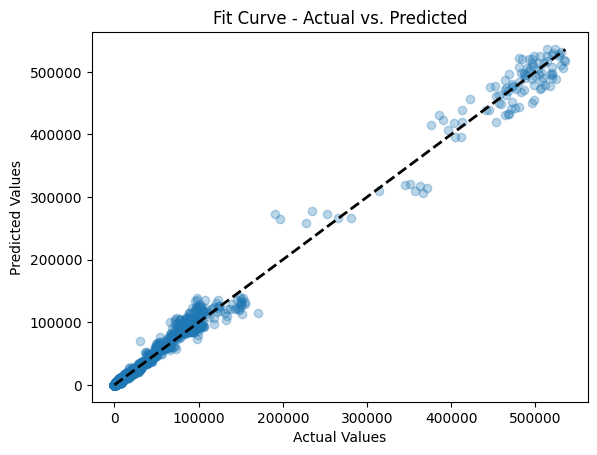

In [11]:
model = DeepAR(device=torch.device('cuda'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/ads_506/deepAR.pth'))
model = model.cuda()
# Move model to the appropriate device
model = model.to(torch.device('cuda'))
test_metrics = evaluate(model)


In [12]:
test_metrics

{'RMSE': 1566.9567957312179, 'test_loss': 5.518671586825186}